## EDA

In [1]:
import time
import torch

from torch import nn, Tensor
from torch.utils.data import DataLoader

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')


In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)

Using cpu.


In [4]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x


# TODO: need to resolve temporal locality problem maybe with a CNN later.
class MLP(nn.Module):
    def __init__(self, input_dim: int, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim + time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)

        return output.reshape(*sz)

In [5]:
def collate_fn(batch):
    observations = [torch.as_tensor(x.observations) for x in batch]
    actions = [torch.as_tensor(x.actions) for x in batch]
    rewards = [torch.as_tensor(x.rewards) for x in batch]
    terminations = [torch.as_tensor(x.terminations) for x in batch]
    truncations = [torch.as_tensor(x.truncations) for x in batch]
    episode_lengths = torch.tensor([len(x.actions) for x in batch], dtype=torch.long)

    return {
        "id": torch.Tensor([x.id for x in batch]),
        "observations": torch.nn.utils.rnn.pad_sequence(
            observations,
            batch_first=True
        ),
        "actions": torch.nn.utils.rnn.pad_sequence(
            actions,
            batch_first=True
        ),
        "rewards": torch.nn.utils.rnn.pad_sequence(
            rewards,
            batch_first=True
        ),
        "terminations": torch.nn.utils.rnn.pad_sequence(
            terminations,
            batch_first=True
        ),
        "truncations": torch.nn.utils.rnn.pad_sequence(
            truncations,
            batch_first=True
        ),
        "episode_lengths": episode_lengths
    }

In [6]:
def get_dataset_stats(dataset):
    loader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)
    
    all_obs, all_act = [], []
    for batch in loader:
        for i in range(batch['observations'].shape[0]):
            length = batch['episode_lengths'][i]
            all_obs.append(batch['observations'][i, :length])
            all_act.append(batch['actions'][i, :length])

    flat_obs = torch.cat(all_obs, dim=0)
    flat_act = torch.cat(all_act, dim=0)

    stats = {
        "obs_mean": torch.mean(flat_obs, dim=0),
        "obs_std": torch.std(flat_obs, dim=0),
        "act_mean": torch.mean(flat_act, dim=0),
        "act_std": torch.std(flat_act, dim=0)
    }
    # Add a small epsilon to prevent division by zero
    stats["obs_std"][stats["obs_std"] < 1e-6] = 1e-6
    stats["act_std"][stats["act_std"] < 1e-6] = 1e-6
    print("Statistics calculation complete.")
    return stats


In [7]:
def create_trajectory_chunks(batch, horizon):
    """
    Processes a padded batch to create fixed-size trajectory chunks.
    """
    batch_size = batch['observations'].shape[0]
    all_chunks = []

    for i in range(batch_size):
        # Get the data for one episode and its true length
        obs = batch['observations'][i]      # Shape: (max_len, 8)
        act = batch['actions'][i]          # Shape: (max_len-1, 2)
        length = batch['episode_lengths'][i]       # Scalar, e.g., 495

        # A single episode can produce multiple chunks
        # We slide a window of size 'horizon' over the valid part of the episode
        for start_idx in range(length - horizon + 1):
            end_idx = start_idx + horizon

            # Slice the observation and action sequences to get a chunk
            obs_chunk = obs[start_idx:end_idx] # Shape: (horizon, 8)
            act_chunk = act[start_idx:end_idx] # Shape: (horizon, 2)
            
            # Combine them into a single (horizon, 10) tensor
            chunk = torch.cat([obs_chunk, act_chunk], dim=-1)

            # Flatten the chunk to the final 1000-D vector and add to our list
            all_chunks.append(chunk.flatten())

    if not all_chunks:
        return None

    return torch.stack(all_chunks)

def create_normalized_chunks(batch, horizon, stats):
    obs_mean, obs_std = stats['obs_mean'], stats['obs_std']
    act_mean, act_std = stats['act_mean'], stats['act_std']

    all_chunks = []
    for i in range(batch['observations'].shape[0]):
        obs, act, length = batch['observations'][i], batch['actions'][i], batch['episode_lengths'][i]
        
        if length < horizon:
            continue
            
        for start_idx in range(length - horizon + 1):
            end_idx = start_idx + horizon
            
            obs_chunk = obs[start_idx:end_idx]
            act_chunk = act[start_idx:end_idx]
            
            # apply normalization
            norm_obs_chunk = (obs_chunk - obs_mean) / obs_std
            norm_act_chunk = (act_chunk - act_mean) / act_std

            chunk = torch.cat([norm_obs_chunk, norm_act_chunk], dim=-1)
            all_chunks.append(chunk.flatten())

    if not all_chunks:
        return None
    return torch.stack(all_chunks)


def unnormalize_trajectory(norm_trajectory_chunk, stats, horizon, obs_dim, action_dim):
    obs_mean, obs_std = stats['obs_mean'], stats['obs_std']
    act_mean, act_std = stats['act_mean'], stats['act_std']
    
    # Reshape to (horizon, obs_dim + action_dim)
    reshaped_chunk = norm_trajectory_chunk.reshape(horizon, obs_dim + action_dim)
    
    norm_obs = reshaped_chunk[:, :obs_dim]
    norm_act = reshaped_chunk[:, obs_dim:]
    
    # Apply the reverse transformation: (data * std) + mean
    unnorm_obs = (norm_obs * obs_std) + obs_mean
    unnorm_act = (norm_act * act_std) + act_mean
    
    return unnorm_obs, unnorm_act

In [8]:
# load minari dataset
import minari
import random
horizon = 100
obs_dim = 8
action_dim = 2

def visualize_chunk(ax, chunk, color, x_limits=(-0.4, 0.4), y_limits=(-0.2, 1.5), mode='line'):
    # make sure chunk is horizon x obs_dim
    assert chunk.shape == (horizon , obs_dim,)
    x = chunk[:, 0].cpu().numpy()
    y = chunk[:, 1].cpu().numpy()
    if mode == 'line':
        ax.plot(x, y, linestyle='-', color=color, alpha=0.7)
    elif mode == 'scatter':
        ax.scatter(x, y, color=color, alpha=0.7)
    ax.set_xlim(*x_limits)
    ax.set_ylim(*y_limits)
    ax.grid(True)

minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
minari_dataset_stats = get_dataset_stats(minari_dataset)
minari_dataset_stats

Statistics calculation complete.


{'obs_mean': tensor([-3.8224e-03,  4.5600e-01, -1.2215e-02, -2.1999e-01,  8.3548e-03,
          5.4869e-05,  1.5350e-01,  1.5069e-01]),
 'obs_std': tensor([0.1204, 0.4510, 0.1873, 0.1716, 0.1091, 0.0863, 0.3605, 0.3577]),
 'act_mean': tensor([-0.0279,  0.0534]),
 'act_std': tensor([0.5133, 0.3983])}

## Trajectory Visualization from Expert Dataset

Visualizing with normalized chunks...


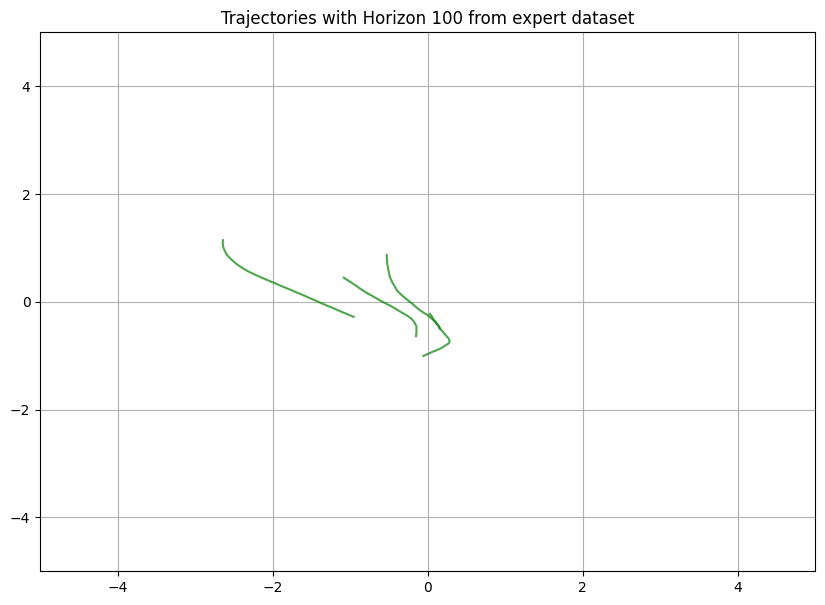

In [9]:

dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with Horizon {horizon} from expert dataset')
print("Visualizing with normalized chunks...")
for batch in dataloader:
    # processed_chunks = create_trajectory_chunks(batch, 100)
    processed_chunks = create_normalized_chunks(batch, horizon, minari_dataset_stats)
    random_chunk = random.choice(processed_chunks)
    assert random_chunk.shape == (horizon * (obs_dim + action_dim),)
    random_chunk = random_chunk.reshape(horizon, obs_dim + action_dim)
    expert_obs = random_chunk[:, :obs_dim]
    visualize_chunk(ax, expert_obs, color="green", mode="line", x_limits=(-5,5), y_limits=(-5, 5))

## Training

In [ ]:
from src.utils.loggers import WandBLogger
env = minari_dataset.recover_environment()
horizon = 100
action_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
input_dim = (obs_dim + action_dim) * horizon

# Training params
lr = 0.001
num_epochs = 1000
print_every = 100
hidden_dim = 256

config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "lr": lr
}

logger = WandBLogger(config = config)
vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("Starting training...")
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    total_chunks = 0
    start_time = time.time()

    for batch in dataloader:
        optim.zero_grad()

        # x_1 = create_trajectory_chunks(batch, horizon)
        x_1 = create_normalized_chunks(batch, horizon, minari_dataset_stats)
        if x_1 is None:
            continue
        x_1 = x_1.to(device)
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0]).to(device)

        # 3. Forward pass and Loss
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        predicted_velocity = vf(path_sample.x_t, path_sample.t)
        loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

        # 4. Backward pass and Optimize
        loss.backward()
        optim.step()
        total_epoch_loss += loss.item()
        total_chunks += 1

    avg_epoch_loss = total_epoch_loss / total_chunks if total_chunks > 0 else 0
    logger.log({"avg_epoch_loss": avg_epoch_loss})
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| Epoch {epoch+1:6d} | {elapsed:.2f} s/epoch | Loss {avg_epoch_loss:8.5f} ")
        start_time = time.time()
print("Training finished.")

avg_epoch_loss,█████▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
avg_epoch_loss,1.16664


Starting training...
| Epoch     10 | 5.51 s/epoch | Loss  1.22070 
| Epoch     20 | 5.77 s/epoch | Loss  1.16102 
| Epoch     30 | 5.43 s/epoch | Loss  1.14287 
| Epoch     40 | 5.60 s/epoch | Loss  1.13374 
| Epoch     50 | 5.52 s/epoch | Loss  1.12679 
| Epoch     60 | 5.38 s/epoch | Loss  1.12146 
| Epoch     70 | 5.44 s/epoch | Loss  1.11704 
| Epoch     80 | 5.37 s/epoch | Loss  1.11445 
| Epoch     90 | 5.43 s/epoch | Loss  1.11207 
| Epoch    100 | 5.55 s/epoch | Loss  1.10954 
Training finished.


## Sampling

In [36]:
# try sampling from trained model...
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)


wrapped_vf = WrappedModel(vf)
step_size = 0.05
batch_size = 1  # batch size
T = torch.linspace(0, 1, 10)  # sample times
T = T.to(device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class


def generate_trajectory():
    x_init = torch.randn((batch_size, input_dim), dtype=torch.float32, device=device)
    sol = solver.sample(
        time_grid=T,
        x_init=x_init,
        method="midpoint",
        step_size=step_size,
        return_intermediates=True,
    )
    final_trajectory = sol[-1].reshape(horizon, obs_dim + action_dim)

    obs, act = unnormalize_trajectory(
        final_trajectory.flatten(), minari_dataset_stats, horizon, obs_dim, action_dim
    )

    # obs = final_trajectory[:, :obs_dim]
    # act = final_trajectory[:, obs_dim:obs_dim + action_dim]
    return obs, act

Generating new trajectory...
Generating new trajectory...
Generating new trajectory...
Generating new trajectory...


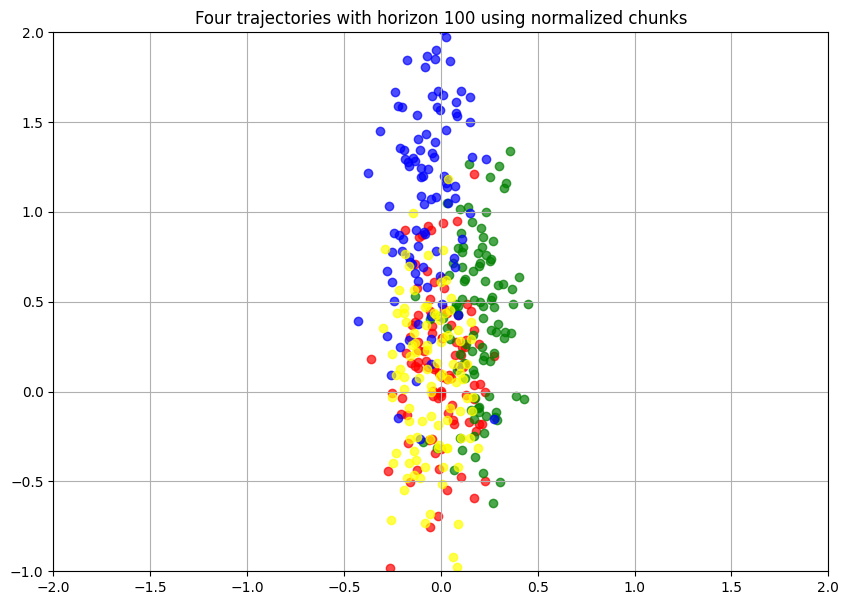

In [87]:
fig, ax = plt.subplots(figsize=(10, 7))
observations, actions = generate_trajectory()
ax.set_title(f'Four trajectories with horizon {horizon} using normalized chunks')

# visulizing 4 trajectories
for _ in range(4):
    colors = ['red', 'green', 'blue', 'yellow']
    print("Generating new trajectory...")
    observations, actions = generate_trajectory()
    visualize_chunk(ax, observations, color=colors[_],
                    x_limits=(-2, 2), y_limits=(-1, 2), mode='scatter')

In [49]:
observations, actions = generate_trajectory()
observations

tensor([[ 6.2956e-02,  4.6967e-01, -3.6204e-02, -8.6150e-02, -7.0379e-03,
         -1.2734e-01, -1.0344e+00,  2.5084e-01],
        [ 3.2303e-01,  2.3374e-01, -1.7355e-01,  3.5278e-02, -1.4114e-01,
          1.3736e-03, -2.1346e-01, -1.8196e-01],
        [ 1.6815e-01, -1.3625e-02, -3.1221e-01,  2.9812e-02,  1.7238e-02,
          3.6549e-02, -4.6146e-01, -2.4894e-01],
        [-8.6655e-02, -2.5907e-01, -3.7613e-01, -1.5994e-01,  7.7013e-02,
          4.8848e-02,  7.7857e-02, -4.4261e-01],
        [ 1.8848e-01,  4.8647e-01, -9.0399e-02, -2.1647e-01,  5.9825e-02,
         -1.1675e-02, -1.2652e-01,  3.7884e-01],
        [ 4.5760e-03,  4.1349e-01, -1.5132e-01, -1.4187e-01, -2.0863e-02,
          3.9718e-02,  2.8556e-01, -6.0875e-01],
        [ 1.4480e-01,  1.1424e-01,  8.2362e-02, -3.1712e-01,  2.3588e-01,
         -5.4350e-02,  4.7168e-01, -4.0803e-01],
        [ 1.8460e-01,  1.0713e-01, -3.4588e-02, -6.2269e-02,  1.5528e-01,
          1.8685e-02,  4.6654e-01, -9.9737e-02],
        [ 1.9426

In [52]:
horizon = 100
num_eval_episodes = 100
env = minari_dataset.recover_environment(eval_env = True)
model_rewards = []
random_rewards = []
for eps in range(num_eval_episodes):
    obs, _ = env.reset()
    total_rew = 0
    obs, actions = generate_trajectory()
    for i in range(horizon):
        action = actions[i].cpu().numpy()
        obs, rew, terminated, truncated, info = env.step(action)
        total_rew += rew
        if terminated or truncated:
            break
    model_rewards.append(total_rew)

    env.reset()
    total_rew_random = 0
    for i in range(horizon):
        action = env.action_space.sample()
        obs, rew, terminated, truncated, info = env.step(action)
        total_rew_random += rew
        if terminated or truncated:
            break
    random_rewards.append(total_rew_random)
    if (eps + 1) % 10 == 0:
        print(f"Finished episode {eps + 1}/{num_eval_episodes} - Model Reward: {total_rew}, Random Reward: {total_rew_random}")
env.close()
print("Evaluation finished.")


Finished episode 10/100 - Model Reward: -192.8700771818713, Random Reward: -188.3357817979424
Finished episode 20/100 - Model Reward: -64.09468973575761, Random Reward: -212.98812688138722
Finished episode 30/100 - Model Reward: -474.06995216143383, Random Reward: -128.82188139279748
Finished episode 40/100 - Model Reward: -273.55101054163435, Random Reward: -220.81846856456175
Finished episode 50/100 - Model Reward: -173.59328696743677, Random Reward: -119.09430954846611
Finished episode 60/100 - Model Reward: -536.931911231939, Random Reward: -60.05257475460127
Finished episode 70/100 - Model Reward: -179.45538804732493, Random Reward: -17.444932806175252
Finished episode 80/100 - Model Reward: -171.35179663487384, Random Reward: -193.8260620578572
Finished episode 90/100 - Model Reward: -566.0786673306559, Random Reward: -21.95657731560732
Finished episode 100/100 - Model Reward: -282.1711192997768, Random Reward: -13.373851290462005
Evaluation finished.


In [55]:

horizon = 100
minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
env = minari_dataset.recover_environment(eval_env=True, render_mode="human")

obs, _ = env.reset()
total_rew_random = 0
obs, actions = generate_trajectory()
total_rew = 0
for i in range(horizon):
    action = actions[i].cpu().numpy()
    obs, rew, terminated, truncated, info = env.step(action)
    total_rew += rew
    if terminated or truncated:
        break
env.close()